# Importing the Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import shutil
from keras.layers import Input,Dense,LSTM,Embedding,Dropout,GRU
from keras.layers.wrappers import Bidirectional
from keras.layers import Permute,TimeDistributed,Reshape,Activation,Dot
from keras import Model
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
import pickle
import string
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
import re
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


Using TensorFlow backend.


In [2]:
DATA_DIR = os.path.join(os.getcwd(),"dataset",)
MODEL_PATH = os.path.join(os.getcwd(),"model",)
GLOVE_DIR = os.path.join(os.getcwd(),"glove")

In [3]:
if not os.path.exists(DATA_DIR):
    print("Data does not exists--->")
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(GLOVE_DIR):
    os.makedirs(GLOVE_DIR)

# Data Preparation

In [4]:
data = pd.read_csv(os.path.join(DATA_DIR,"train.csv"))

In [5]:
print("Number of rows ",data.shape[0])
print("Number of columns",data.shape[1])

Number of rows  3235
Number of columns 6


In [6]:
data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


## Preprocessing the text

In [7]:
def preprocess_tweet(text):

    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # convert text to lower-case
    nopunc = nopunc.lower()
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', nopunc)
    nopunc = re.sub(r'http\S+', '', nopunc)
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    # remove the # in #hashtag
    nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    nopunc = re.sub(r'\w*\d\w*', '', nopunc).strip()
    # remove repeated characters
    nopunc = word_tokenize(nopunc)
    # remove stopwords from final word list
    return " ".join([str(word) for word in nopunc if word not in stopwords.words('english')])

In [8]:
data['original_text'] = data['original_text'].apply(lambda x:preprocess_tweet(x))

## Parameters for Glove word Embeddings

In [9]:
MAX_SEQUENCE_LENGTH = 64
MAX_FEATURES = 5000
MAX_NB_WORDS = 24000
EMBEDDING_DIM = 50

## Setting up embedding matrix

In [10]:
def setup_embedding_index():
    embedding_index = dict()
    f = open(os.path.join(GLOVE_DIR,"glove.6B.50d.txt"),encoding="utf-8")
    for line in f:
        values = line.split(" ")
        word = values[0]
        coefs = np.array(values[1:])
        embedding_index[word] = coefs
    f.close()
    return embedding_index

embeddings_index = setup_embedding_index()


## Removing Unneccessary Columns

In [11]:
data = data.drop(['lang','retweet_count','original_author'],axis=1)

In [12]:
data.head()

,id,original_text,sentiment_class
0,1.245025e+18,happy mothersday amazing mothers know hard abl...,0
1,1.245759e+18,happy mothers day mum im sorry cant bring moth...,0
2,1.246087e+18,happy mothers day mothers days work today quie...,-1
3,1.244803e+18,happy mothers day beautiful womanroyalty sooth...,0
4,1.244876e+18,remembering amazing ladies made late grandmoth...,-1


In [13]:
data.columns = ['id','text','sentiment_class']

In [14]:
data.head()

,id,text,sentiment_class
0,1.245025e+18,happy mothersday amazing mothers know hard abl...,0
1,1.245759e+18,happy mothers day mum im sorry cant bring moth...,0
2,1.246087e+18,happy mothers day mothers days work today quie...,-1
3,1.244803e+18,happy mothers day beautiful womanroyalty sooth...,0
4,1.244876e+18,remembering amazing ladies made late grandmoth...,-1


In [15]:
tokenizer = Tokenizer(num_words=75000,split=' ') #num words informd the 
tokenizer.fit_on_texts(data.loc[:,'text'].values)
vocab_length = len(tokenizer.word_index)+1
NUM_WORDS = vocab_length

In [16]:
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
labels_list = list(set(data['sentiment_class'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data['sentiment_class'].replace(labels_id,inplace=True)
labels = to_categorical(data['sentiment_class'])

{0: 0, 1: 1, -1: 2}


In [18]:
count_non_zero=0
embedding_matrix = np.zeros((NUM_WORDS, EMBEDDING_DIM))
for word,i in tokenizer.word_index.items():
    if i>vocab_length-1:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        count_non_zero+=1
        embedding_matrix[i] = embedding_vector

In [19]:
encoded_docs= tokenizer.texts_to_sequences(data.loc[:,'text'])
padded_docs_text = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
# print(vocab_length)

## Model Architecture

In [20]:
input_text = Input(shape=[MAX_SEQUENCE_LENGTH],name='input_text')
embedding = Embedding(vocab_length,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH)(input_text)
drop_em = Dropout(0.2)(embedding)
lstm_outs = Bidirectional(LSTM(EMBEDDING_DIM,return_sequences=True))(drop_em)
drop_lstm = Dropout(0.2)(lstm_outs)

# Attention Mechanism - Generate attention vectors
input_dim = int(drop_lstm.shape[2])
permuted_inputs = Permute((2, 1))(lstm_outs)
attention_vector = TimeDistributed(Dense(1))(drop_lstm)
attention_vector = Reshape((MAX_SEQUENCE_LENGTH,))(attention_vector)
attention_vector = Activation('softmax', name='attention_vec')(attention_vector)
attention_output = Dot(axes=1)([drop_lstm, attention_vector])


# Last layer: fully connected with softmax activation
dense = Dense(EMBEDDING_DIM, activation='relu')(attention_output)
output = Dense(3, activation='softmax')(dense)

# Finally building model
model = Model(inputs=[input_text], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 64)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 64, 50)       571550      input_text[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 64, 50)       0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64, 100)      40400       dropout_1[0][0]                  
____________________________________________________________________________________________

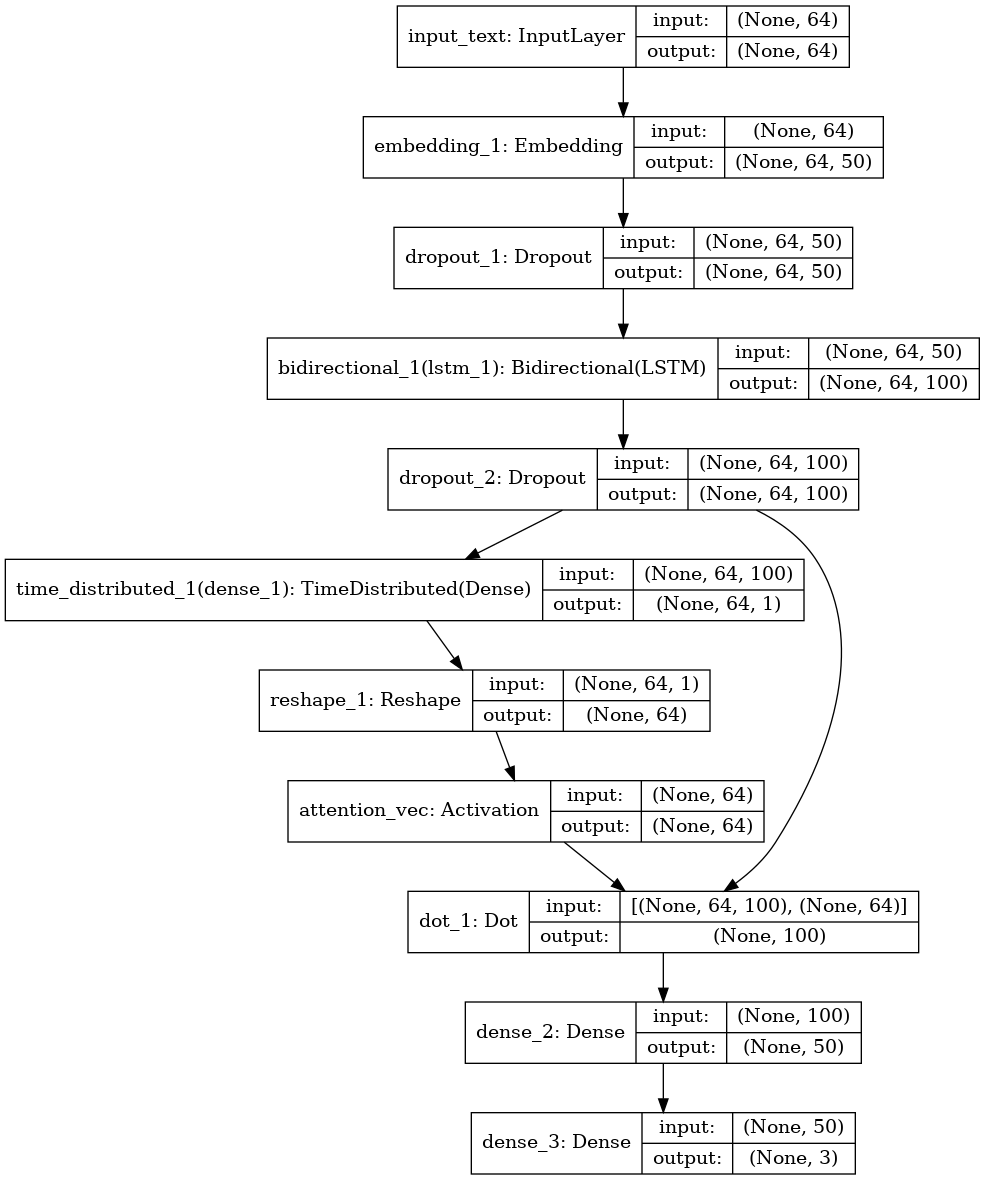

In [22]:

plot_model(model,to_file="model_attention.png",show_shapes=True,show_layer_names=True)

In [23]:
X = padded_docs_text
Y = labels

In [24]:
filepath = os.path.join(MODEL_PATH,"emotions-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

## Model Training

In [25]:
model_history = model.fit(X, Y, epochs=25, batch_size=64, validation_split=0.1, shuffle=True,callbacks=callbacks_list)

/home/abhinav/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2911 samples, validate on 324 samples
Epoch 1/25
2911/2911 [==============================] - 5s 2ms/step - loss: 1.0400 - accuracy: 0.5239 - val_loss: 1.0091 - val_accuracy: 0.5432

Epoch 00001: val_accuracy improved from -inf to 0.54321, saving model to /home/abhinav/mothers_day_tweets/model/emotions-01-0.54.hdf5
Epoch 2/25
2911/2911 [==============================] - 4s 1ms/step - loss: 1.0208 - accuracy: 0.5239 - val_loss: 1.0068 - val_accuracy: 0.5432

Epoch 00002: val_accuracy did not improve from 0.54321
Epoch 3/25
2911/2911 [==============================] - 4s 1ms/step - loss: 1.0154 - accuracy: 0.5239 - val_loss: 1.0095 - val_accuracy: 0.5432

Epoch 00003: val_accuracy did not improve from 0.54321
Epoch 4/25
2911/2911 [==============================] - 5s 2ms/step - loss: 0.8946 - accuracy: 0.5696 - val_loss: 1.1928 - val_accuracy: 0.4290

Epoch 00004: val_accuracy did not improve from 0.54321
Epoch 5/25
2911/2911 [==============================] - 5s 2ms/step - loss

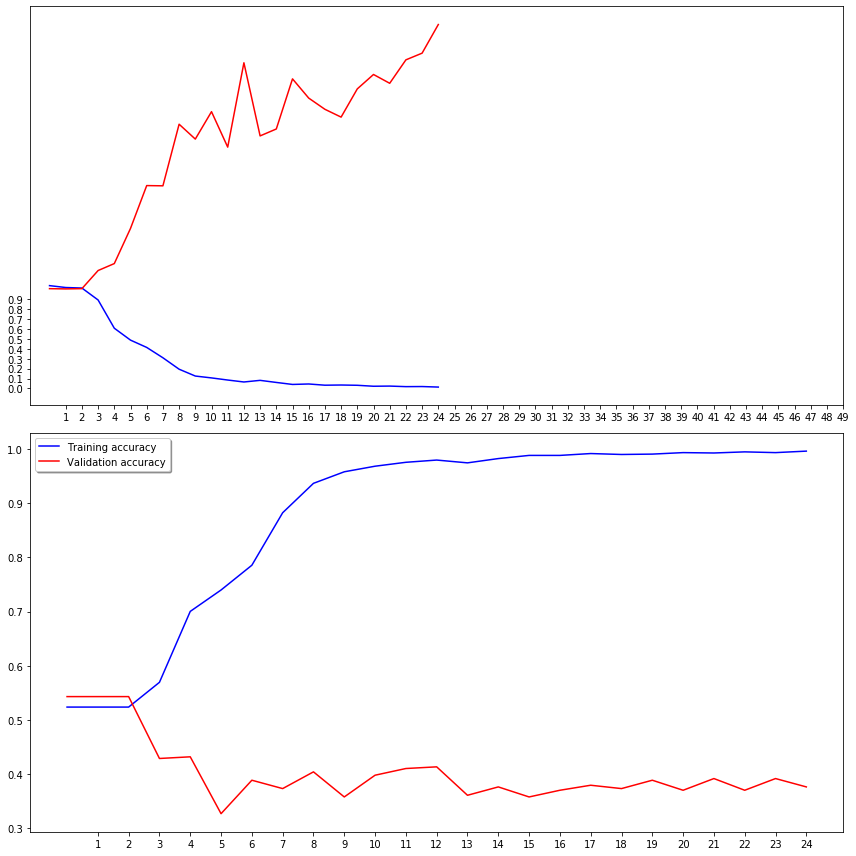

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis

## Confusion matrix

In [27]:
xtrain,xtest,ytrain,ytest = train_test_split(X,Y)

In [28]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig("confusion_matrix.png")
    return fig


In [29]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)


In [30]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = model.predict(xtest,verbose=1)

809/809 [==============================] - 0s 541us/step


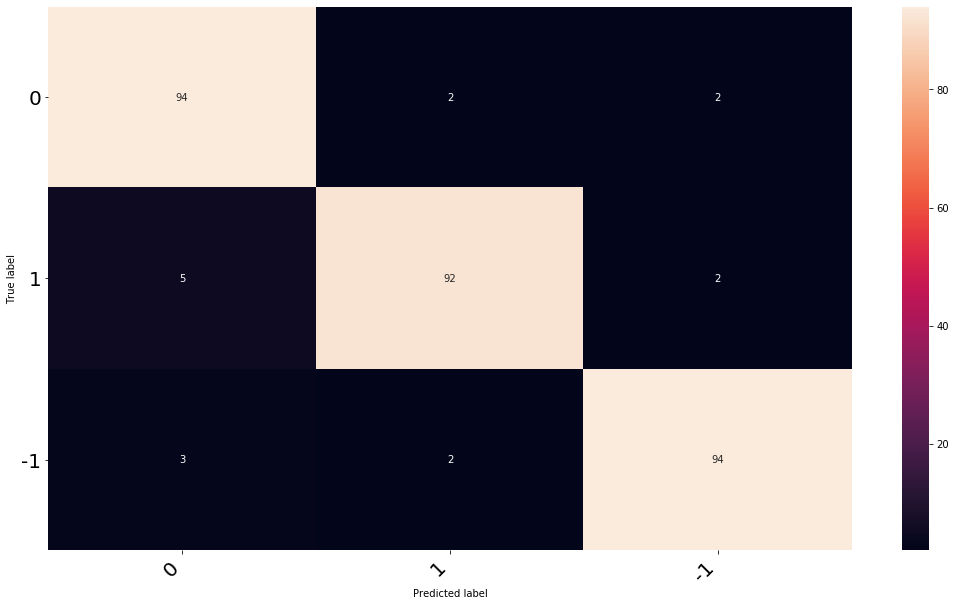

In [31]:
print_heatmap(ytest,ypred,class_names)

## Precision Recall F1 Score

In [32]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)
# print(ypred_class.shape)
# print(ypred.shape)
# print(ytest.shape)

In [33]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.939431
Precision: 0.939726
Recall: 0.939431
F1 score: 0.939524


In [34]:
with open("labels_list.pickle","wb") as handle:
    pickle.dump(labels_list,handle)

# Testing on the labelled training data

In [35]:
Y_pred = model.predict(X)
Y_pred_class = np.argmax(Y_pred,axis=1)
# Y_pred_class[:10]

id_labels = dict()
for label,idx in labels_id.items():
    id_labels[idx] = label
print(id_labels)

for i in range(len(Y_pred_class)):
    data.loc[i,'Prediction'] = int(id_labels[Y_pred_class[i]])

# data.to_csv(os.path.join(os.getcwd(),"csv_files","results.csv"),index=False)

{0: 0, 1: 1, 2: -1}


In [36]:
for i in range(data.shape[0]):
    data.loc[i,'sentiment_class'] = id_labels[data.loc[i,'sentiment_class']]
data['Prediction'] = data['Prediction'].astype(int)

data.to_csv(os.path.join(os.getcwd(),"csv_files","results.csv"),index=False)

In [37]:
data.head()

,id,text,sentiment_class,Prediction
0,1.245025e+18,happy mothersday amazing mothers know hard abl...,0,0
1,1.245759e+18,happy mothers day mum im sorry cant bring moth...,0,0
2,1.246087e+18,happy mothers day mothers days work today quie...,-1,-1
3,1.244803e+18,happy mothers day beautiful womanroyalty sooth...,0,0
4,1.244876e+18,remembering amazing ladies made late grandmoth...,-1,-1


In [38]:
print("Total Size of data is",data.shape[0])
count=0
for i in range(data.shape[0]):
    if data.iloc[i,2]==data.iloc[i,2]:
        count+=1
print("Total correct entries is ",count)

Total Size of data is 3235
Total correct entries is  3235


# Test model by input text from user

In [39]:
input_text = input("Enter the query")
encoded_docs= tokenizer.texts_to_sequences([input_text])
padded_docs_text = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
input_pred = model.predict(padded_docs_text)
ypred_class = np.argmax(input_pred,axis=1)
print("Predicted class-->",id_labels[ypred_class[0]])

Enter the queryWhat a great day to show you my project
Predicted class--> 0


# Creating the Submission File

In [40]:
data_test = pd.read_csv(os.path.join(DATA_DIR,"test.csv"))
print("Number of test samples",data_test.shape[0])
print("Shape of  data_test",data_test.shape)

Number of test samples 1387
Shape of  data_test (1387, 5)


In [41]:
data_test.head()

,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg


In [42]:
def predict_class(input_text):
    encoded_docs= tokenizer.texts_to_sequences([input_text])
    padded_docs_text = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    input_pred = model.predict(padded_docs_text)
    ypred_class = np.argmax(input_pred,axis=1)
    return id_labels[ypred_class[0]]

In [43]:
data_test.head()

,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg


In [44]:
data_test['original_text'] = data_test['original_text'].apply(lambda x:preprocess_tweet(x))
data_test['sentiment_class'] = data_test['original_text'].apply(lambda x:predict_class(x))
#removing the not important classes for generating the submission file
data_test = data_test.drop(['original_text','lang','retweet_count','original_author'],axis=1)

In [45]:
data_test.head()

,id,sentiment_class
0,1.246628e+18,0
1,1.245898e+18,0
2,1.244717e+18,1
3,1.245730e+18,1
4,1.244636e+18,-1


In [46]:
# This resulted in a leaderboard score of 37.16765

In [47]:
data_test.to_csv("submission.csv",index=False)

![](images/leaderboard_glove.png)